# Mount from drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! git clone https://gitlab.com/bigirqu/quranqa.git

Cloning into 'quranqa'...
remote: Enumerating objects: 333, done.
remote: Counting objects: 100% (86/86), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 333 (delta 43), reused 86 (delta 43), pack-reused 247
Receiving objects: 100% (333/333), 312.88 KiB | 7.45 MiB/s, done.
Resolving deltas: 100% (130/130), done.


In [3]:
! pip install python-bidi
! pip install arabic-reshaper

# Load Libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
from bidi.algorithm import get_display
from arabic_reshaper import reshape
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk

In [5]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# Load data

In [6]:
def read_data_from_json(path):
    # Define empty lists for the JSON objects and answers
    data = []
    answers_data = []
    # Open the JSON file and read it line-by-line
    with open(path, 'r') as f:
        # Use a generator expression to read the lines of the JSON file
        lines = (line.strip() for line in f)
        # Use json.JSONDecoder() to parse the JSON objects incrementally
        decoder = json.JSONDecoder()
        for line in lines:
            # Decode the JSON object and append it to the list
            obj, _ = decoder.raw_decode(line)
            data.append(obj)
            # Extract the ID from the JSON object and add it to each answer
            id = obj["pq_id"]
            for answer in obj["answers"]:
                answer["pq_id"] = id
                answers_data.append(answer)

    # Convert the list of answer dictionaries into a pandas DataFrame
    answer_df = pd.json_normalize(answers_data)

    # Convert the list of JSON objects into a pandas DataFrame
    all_data = pd.json_normalize(data)

    # Merge the two DataFrames on the 'pq_id' column
    merged_data = pd.merge(all_data, answer_df, on="pq_id")
    merged_data = merged_data.drop(columns=["answers"])
    merged_data = merged_data.rename(columns={"text":"answer"})
    # Return the merged DataFrame
    return merged_data

In [7]:
train = read_data_from_json("/content/quranqa/datasets/qrcd_v1.1_train.jsonl")
validation = read_data_from_json("/content/quranqa/datasets/qrcd_v1.1_dev.jsonl")
test = read_data_from_json("/content/quranqa/datasets/qrcd_v1.1_test_gold.jsonl")

# Explore Dataset

In [8]:
print(f"shape of train data is {train.shape}.")
print(f"shape of validation data is {validation.shape}.")
print(f"shape of test data is {test.shape}.")

shape of train data is (861, 7).
shape of validation data is (128, 7).
shape of test data is (300, 7).


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 861 entries, 0 to 860
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   pq_id       861 non-null    object
 1   passage     861 non-null    object
 2   surah       861 non-null    int64 
 3   verses      861 non-null    object
 4   question    861 non-null    object
 5   answer      861 non-null    object
 6   start_char  861 non-null    int64 
dtypes: int64(2), object(5)
memory usage: 53.8+ KB


In [10]:
validation.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 128 entries, 0 to 127
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   pq_id       128 non-null    object
 1   passage     128 non-null    object
 2   surah       128 non-null    int64 
 3   verses      128 non-null    object
 4   question    128 non-null    object
 5   answer      128 non-null    object
 6   start_char  128 non-null    int64 
dtypes: int64(2), object(5)
memory usage: 8.0+ KB


In [11]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300 entries, 0 to 299
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   pq_id       300 non-null    object
 1   passage     300 non-null    object
 2   surah       300 non-null    int64 
 3   verses      300 non-null    object
 4   question    300 non-null    object
 5   answer      300 non-null    object
 6   start_char  300 non-null    int64 
dtypes: int64(2), object(5)
memory usage: 18.8+ KB


In [12]:
column_of_interest = ["pq_id","passage","question","answer","start_char"]

In [13]:
train[column_of_interest].to_csv("/content/train.csv",index=False)
test[column_of_interest].to_csv("/content/test.csv",index=False)
validation[column_of_interest].to_csv("/content/validation.csv",index=False)

#Statstics

In [14]:
train_description = train.describe()
validation_description = validation.describe()
test_description = test.describe()

combined = pd.concat([train_description, validation_description, test_description], axis=1, keys=['Train', 'Validation', 'Test'])

In [15]:
combined

Train               Validation                    Test            
            surah   start_char       surah  start_char       surah  start_char
count  861.000000   861.000000  128.000000  128.000000  300.000000  300.000000
mean    23.785134   182.296167   20.445312  190.062500   21.000000  129.053333
std     23.325933   170.288474   21.319027  160.642497   21.346637  125.294184
min      2.000000     0.000000    2.000000    0.000000    2.000000    0.000000
25%      5.000000    43.000000    4.000000   76.000000    4.000000   15.750000
50%     17.000000   144.000000    9.000000  150.000000   13.000000   98.500000
75%     35.000000   268.000000   33.000000  284.500000   31.250000  209.000000
max    109.000000  1353.000000  109.000000  687.000000   97.000000  578.000000

##Check Duplicated

In [16]:
print(f"Duplicated of train data is {train.duplicated().sum()}.")
print(f"Duplicated of validation data is {validation.duplicated().sum()}.")
print(f"Duplicated of test data is {test.duplicated().sum()}.")

Duplicated of train data is 0.
Duplicated of validation data is 0.
Duplicated of test data is 0.


##Check Nulls

In [17]:
print(f"Null of train data is {train.isnull().sum().sum()}.")
print(f"Null of validation data is {validation.isnull().sum().sum()}.")
print(f"Null of test data is {test.isnull().sum().sum()}.")

Null of train data is 0.
Null of validation data is 0.
Null of test data is 0.


##Compute statistics on passage words count

In [18]:
passage_lengths = train['passage'].apply(lambda x : len(str(x).split()))


mean_length = passage_lengths.mean()
median_length = passage_lengths.median()
std_dev = passage_lengths.std()

# Print the statistics
print(f"Mean passage word counts: {mean_length:.2f}")
print(f"Median passage word counts:: {median_length:.2f}")
print(f"Standard deviation of passage word counts:: {std_dev:.2f}")

Mean passage word counts: 80.64
Median passage word counts:: 74.00
Standard deviation of passage word counts:: 36.66


##Compute the frequency of different topics in the passages

In [19]:
qrcd_df = train.copy()

stop_words = stopwords.words('arabic')
qrcd_df['passage_tokens'] = qrcd_df['passage'].apply(lambda x: [w for w in word_tokenize(x) if w not in stop_words])


topic_counts = {}
for tokens in qrcd_df['passage_tokens']:
    for token in tokens:
        if token in topic_counts:
            topic_counts[token] += 1
        else:
            topic_counts[token] = 1

sorted_topics = sorted(topic_counts.items(), key=lambda x: x[1], reverse=True)

In [20]:
top_topics_df = pd.DataFrame(sorted_topics[:10], columns=['Topic', 'Frequency'])

In [21]:
top_topics_df

,Topic,Frequency
0,.,5040
1,الله,1955
2,قال,513
3,آمنوا,260
4,الأرض,240
5,قالوا,223
6,عليهم,212
7,والله,211
8,قوم,182
9,شيء,178


##Calculate the max and min of answer words count

In [22]:
answer_lengths = train['answer'].apply(lambda x : len(str(x).split()))
print(f"Max answer length: {np.max(answer_lengths)}")
print(f"Min answer length: {np.min(answer_lengths)}")

Max answer length: 225
Min answer length: 1


##Calculate the max and min of passage words count

In [23]:
answer_lengths = train['passage'].apply(lambda x : len(str(x).split()))
print(f"Max passage length: {np.max(answer_lengths)}")
print(f"Min passage length: {np.min(answer_lengths)}")

Max passage length: 302
Min passage length: 21


##Correlation between passage length and answer length

In [24]:
passage_answer_lengths = []
for p in list(train["passage"].unique()):
    for _,a in train[train["passage"] == p].iterrows():
        passage_answer_lengths.append((len(p), len(a["answer"])))
passage_lengths, answer_lengths = zip(*passage_answer_lengths)

print(f"Correlation between passage length and answer length: {np.corrcoef(passage_lengths, answer_lengths)[0,1]:.2f}")

Correlation between passage length and answer length: 0.17


# Display Examples of Question and Answeres

In [25]:
def print_sample(id):
  passage = train.iloc[id]["passage"].split(".")
  passage = '\n'.join(passage)
  question = train.iloc[id]["question"]
  answers = list(train[(train["question"] == question) & (train["passage"] == train.iloc[id]["passage"])]["answer"].values)
  print(f"passage is : \n{passage}")
  print(f"question is : \n{question}")
  for i, answer in enumerate(answers):
    print(f"answer {i+1} is : \n {answer}")

In [26]:
for i in range(5):
    print(f"Example {i + 1}: {print_sample(i)}")
    print("----------------------------------------------")

passage is : 
ومن الناس من يقول آمنا بالله وباليوم الآخر وما هم بمؤمنين
 يخادعون الله والذين آمنوا وما يخدعون إلا أنفسهم وما يشعرون
 في قلوبهم مرض فزادهم الله مرضا ولهم عذاب أليم بما كانوا يكذبون
 وإذا قيل لهم لا تفسدوا في الأرض قالوا إنما نحن مصلحون
 ألا إنهم هم المفسدون ولكن لا يشعرون
 وإذا قيل لهم آمنوا كما آمن الناس قالوا أنؤمن كما آمن السفهاء ألا إنهم هم السفهاء ولكن لا يعلمون
 وإذا لقوا الذين آمنوا قالوا آمنا وإذا خلوا إلى شياطينهم قالوا إنا معكم إنما نحن مستهزئون
 الله يستهزئ بهم ويمدهم في طغيانهم يعمهون
 أولئك الذين اشتروا الضلالة بالهدى فما ربحت تجارتهم وما كانوا مهتدين

question is : 
لماذا سيُحاسب ويُعذب الضال يوم القيامة ان كان ""من يضلل الله فما له من هاد"" كما ورد من قوله تعالى في آية 23 و آية 36 من سورة الزمر؟
answer 1 is : 
 أولئك الذين اشتروا الضلالة بالهدى
Example 1: None
----------------------------------------------
passage is : 
إن الذين يكتمون ما أنزل الله من الكتاب ويشترون به ثمنا قليلا أولئك ما يأكلون في بطونهم إلا النار ولا يكلمهم الله يوم القيامة ولا يزكيهم ول

#Data Analysis and Plots

##Compute the frequency of different question types

In [27]:
import pandas as pd
import seaborn as sns

##Distribution of question types

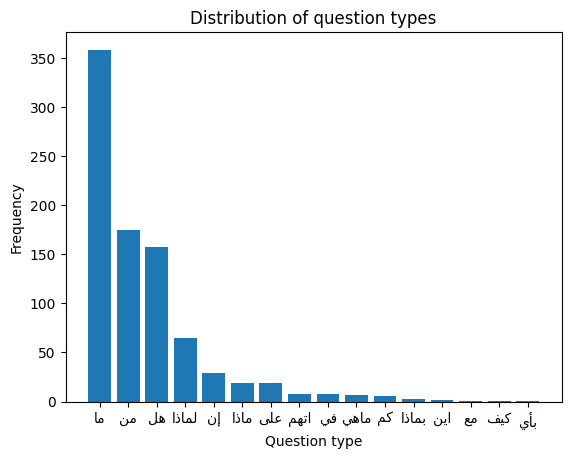

In [28]:
question_types = train['question'].apply(lambda x: x.split()[0])
question_type_counts = question_types.value_counts()

reshaped_labels = [get_display(reshape(label)) for label in question_type_counts.index]


fig, ax = plt.subplots()
ax.bar(reshaped_labels, question_type_counts.values)
ax.set_title('Distribution of question types')
ax.set_xlabel('Question type')
ax.set_ylabel('Frequency')
plt.show()

##Passage length distribution

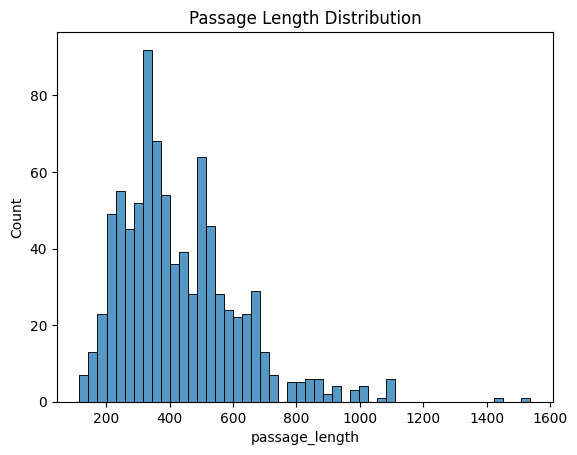

In [29]:
plt.figure()
train["passage_length"] = train["passage"].apply(len)
sns.histplot(train["passage_length"], bins=50)
plt.title("Passage Length Distribution")
plt.show()


##Question length distribution

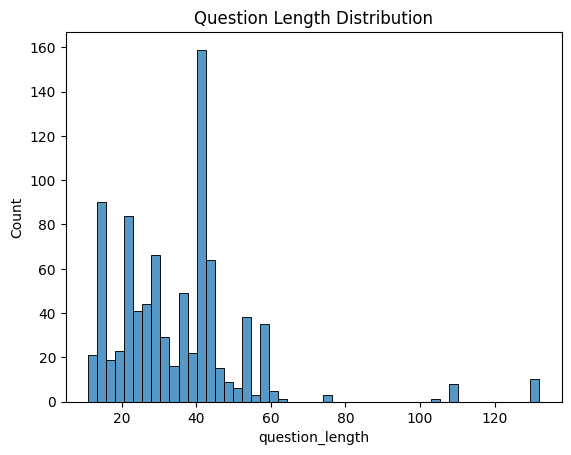

In [30]:
plt.figure()
train["question_length"] = train["question"].apply(len)
sns.histplot(train["question_length"], bins=50)
plt.title("Question Length Distribution")
plt.show()

##Answer length distribution

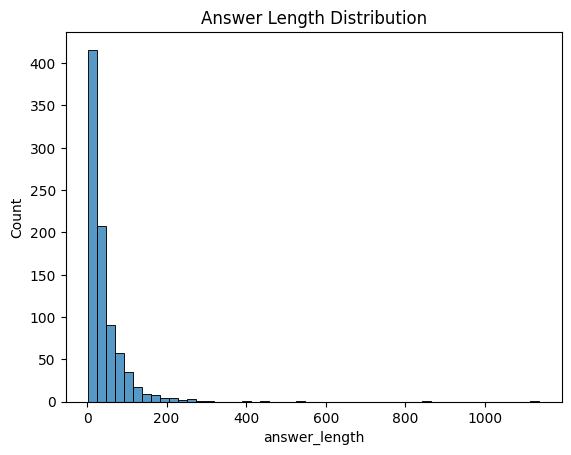

In [31]:
plt.figure()
train["answer_length"] = train["answer"].apply(len)
sns.histplot(train["answer_length"], bins=50)
plt.title("Answer Length Distribution")
plt.show()

##print random samples for question doesn't have question word

In [32]:
for question_type in ["إن","علي","في", "اتهم", "مع"]:
    for question in (
        train[train.question.str.startswith(question_type)]['question'].unique()):
        print(question)

إن كان الله قدّر علي أفعالي فلماذا يحاسبني؟
في كم يوم خلق الله الكون؟
اتهم القرآن بأنه السبب في الدكتاتورية الإسلامية لكونه أباح التكفير وقتال الكفار حتى يسلموا، كيف نرد على ذلك؟
مع أن السؤال هو أساس كل العلوم، لماذا نهى الله المؤمنين عن طرح الأسئلة كما جاء في سورة المائدة آية 101؟


##Analyze the frequency of words in the questions

In [33]:
question_words = [w.lower() for _,q in train.iterrows() for w in q['question'].split()]
question_word_counts = Counter(question_words)
question_top_words = [word for word, count in question_word_counts.most_common(20)]
question_top_counts = [count for word, count in question_word_counts.most_common(20)]
print("Most common words in the questions:")
common_words_df = pd.DataFrame({'Word': question_top_words, 'Count': question_top_counts})
common_words_df

Most common words in the questions:


,Word,Count
0,ما,359
1,في,281
2,من,266
3,هي,258
4,التي,192
5,هل,158
6,القرآن؟,147
7,هم,122
8,القرآن,103
9,الحيوانات,100


##Most Common Words in Questions

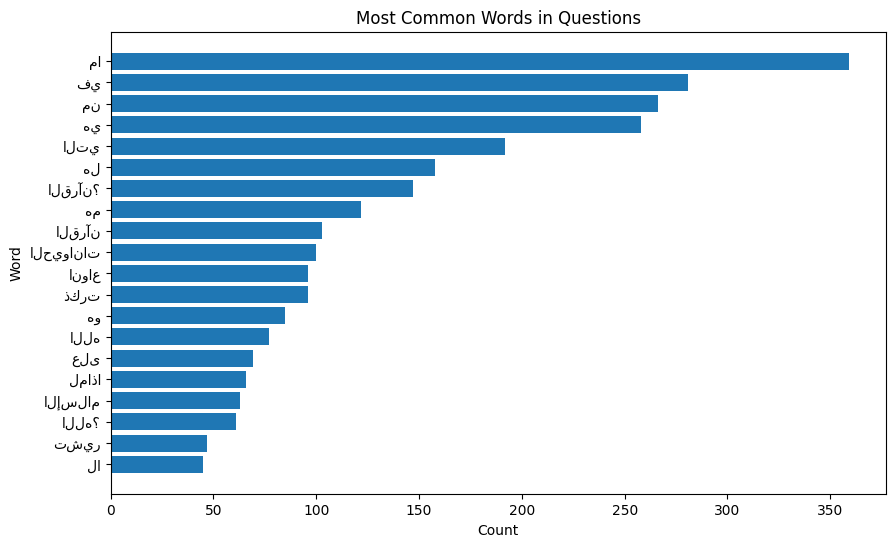

In [34]:
plt.figure(figsize=(10, 6))
plt.barh(common_words_df['Word'], common_words_df['Count'])
plt.xlabel('Count')
plt.ylabel('Word')
plt.title('Most Common Words in Questions')
plt.gca().invert_yaxis()
plt.show()

##Most common words in the Answers

In [35]:
answer_words = [w.lower() for _,q in train.iterrows() for w in q['answer'].split()]
answer_word_counts = Counter(answer_words)
answer_top_words = [word for word, count in answer_word_counts.most_common(20)]
answer_top_counts = [count for word, count in answer_word_counts.most_common(20)]
print("Most common words in the Answers:")
common_words_df_answer = pd.DataFrame({'Word': answer_top_words, 'Count': answer_top_counts})
common_words_df_answer

Most common words in the Answers:


,Word,Count
0,من,310
1,الله,160
2,في,128
3,الذين,110
4,ما,87
5,لا,62
6,إن,58
7,أن,58
8,على,56
9,ولا,55


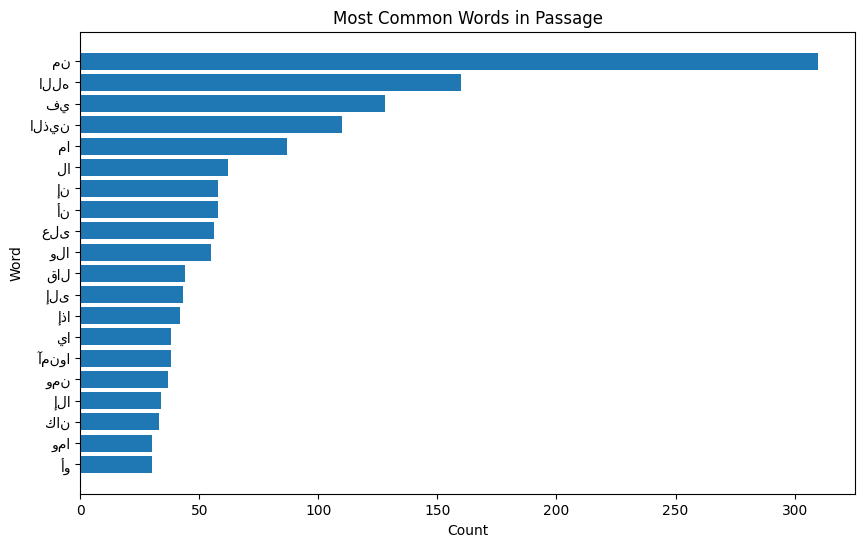

In [36]:
plt.figure(figsize=(10, 6))
plt.barh(common_words_df_answer['Word'], common_words_df_answer['Count'])
plt.xlabel('Count')
plt.ylabel('Word')
plt.title('Most Common Words in Passage')
plt.gca().invert_yaxis()
plt.show()

##Calculate mean answer length for each question type


<ipython-input-37-16a2ecef1680>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(reshaped_labels)


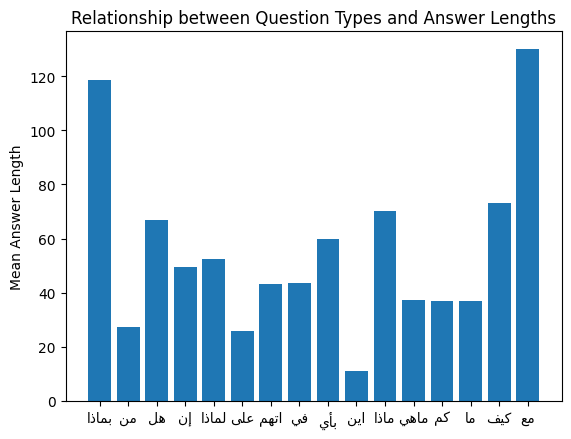

In [37]:
question_types = [q.split()[0].lower() for q in list(train["question"].unique())]
unique_question_types = list(set(question_types))
question_type_answer_lengths = {t: [] for t in unique_question_types}

for q in list(train["question"].unique()):
    t = q.split()[0].lower()
    for _,a in train[train["question"] == q].iterrows():
        question_type_answer_lengths[t].append(len(a["answer"]))
mean_lengths = [np.mean(question_type_answer_lengths[t]) for t in unique_question_types]


fig, ax = plt.subplots()
ax.bar(unique_question_types, mean_lengths)
ax.set_ylabel('Mean Answer Length')
ax.set_title('Relationship between Question Types and Answer Lengths')

reshaped_labels = [get_display(reshape(label)) for label in unique_question_types]
ax.set_xticklabels(reshaped_labels)

plt.show()

##Scatter Plot of Passage Length vs. Answer Length

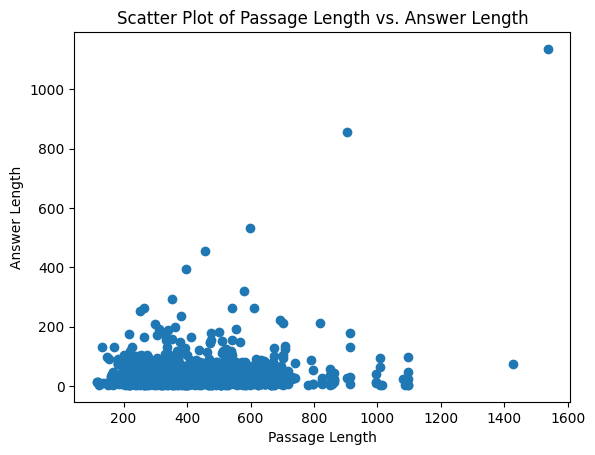

In [38]:
train["passage_length"] = train["passage"].apply(len)
train["answer_length"] = train["answer"].apply(len)

# Create the scatter plot
plt.figure()
plt.scatter(train["passage_length"], train["answer_length"])
plt.xlabel("Passage Length")
plt.ylabel("Answer Length")
plt.title("Scatter Plot of Passage Length vs. Answer Length")
plt.show()

#Word Cloud

##Word Cloud for the Questions

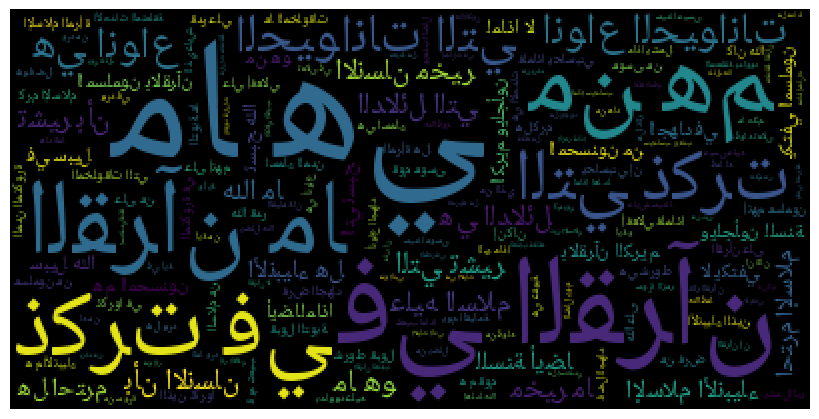

In [40]:
# Combine all the text into a single string
all_text = ' '.join(train['question'].tolist())
# Make text readable for a non-Arabic library like wordcloud
text = reshape(all_text)
text = get_display(text)

# Generate a word cloud image
wordcloud = WordCloud(font_path='/content/font/NotoNaskhArabic-Regular.ttf').generate(text)
# Plot the word cloud
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

##Word Cloud for the Answers

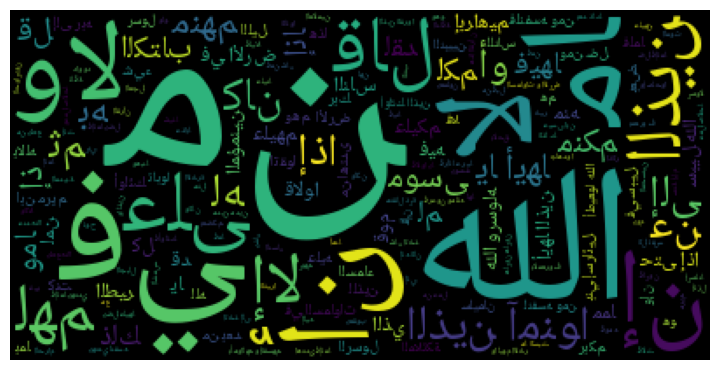

In [41]:
answer=" ".join(train['answer'].tolist())

text=reshape(answer)
text=get_display(text)

wordcloud=WordCloud(font_path='/content/font/NotoNaskhArabic-Regular.ttf').generate(text)

plt.figure(figsize=(7,7))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

##Word Cloud for the Passage

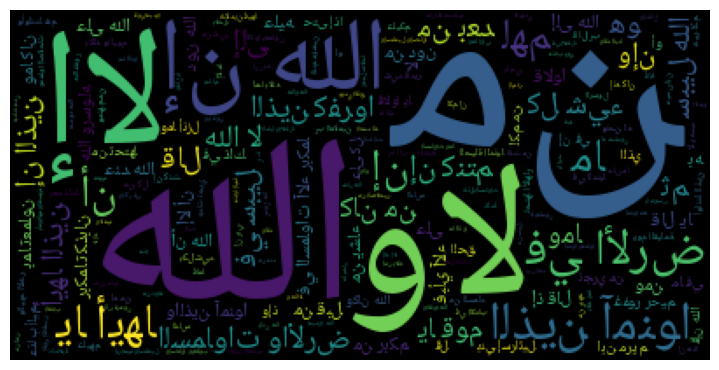

In [42]:
answer=" ".join(train['passage'].tolist())

text=reshape(answer)
text=get_display(text)

wordcloud=WordCloud(font_path='/content/font/NotoNaskhArabic-Regular.ttf').generate(text)

plt.figure(figsize=(7,7))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()